# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
3. Exploratory Sentiment Analysis for full data set
4. Exploratory Sentiment Analysis for BoE Speeches only
5. Exploratory Analysis for Correlation with Economic Indicators
6. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

- All speeches CSV file (all_speeches.csv)
- Sentiment wordlist Excel file (Sentiment-labelled_wordlist-2.xlsx)

### 2.1. Import libraries

In [218]:
# Import relevant libraries.
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [219]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.

stop_words = set(stopwords.words('english'))

# Ensure required NLTK resources are present (quiet=True => no console spam)
for pkg in [
    "punkt",
    "stopwords",
    "vader_lexicon",
]:
    nltk.download(pkg, quiet=True)

import warnings
warnings.filterwarnings("ignore")

### 2.2. Import the data

In [221]:
# Import necessary libraries
import pandas as pd
from IPython.display import display

def load_data(speeches_path: str, sentiment_path: str):
    """
    Load speeches and sentiment wordlist datasets.

    Parameters:
    speeches_path (str): Path to the speeches CSV file.
    sentiment_path (str): Path to the sentiment-labelled wordlist Excel file.

    Returns:
    tuple: A tuple containing two pandas DataFrames (speeches_df, sentiment_df).
    """
    speeches_df = pd.read_csv(speeches_path)
    sentiment_df = pd.read_excel(sentiment_path)
    
    display(speeches_df.head())
    display(sentiment_df.head())
    
    return speeches_df, sentiment_df

# Paths to your files
# speeches_path = r"C:\Users\Srila\OneDrive\Documents\all_speeches.csv"
# sentiment_path = r"C:\Users\Srila\OneDrive\Documents\LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2 (1).xlsx"

# speeches_path = r"/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv"
# sentiment_path = r"/Users/kaferrante/Documents/Python/_Course4_Project/LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx"

speeches_path = r"/Users/christinetsoulfa/Desktop/LSE_Data Analytics/Work Project/Files/all_speeches.csv"
sentiment_path = r"/Users/christinetsoulfa/Desktop/LSE_Data Analytics/Work Project/Files/LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx"

# Load data
speeches_df_org, sentiment_df_org = load_data(speeches_path, sentiment_path)

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0


### 2.3. Explore and Clean Data

### Approach
- Check the data sets and dates
- Are dates parsed properly?
- Are speech texts clean (no missing)?
- Is the sentiment list organized (positive/negative words tagged)?

**2.3.a. Review Datasets**
- Look for missing values, review basic statistics & check data types
- Look at the structure of the speeches and sentiment files

In [224]:
def explore_data(speeches_df_org: pd.DataFrame, sentiment_df_org: pd.DataFrame):
    """
    Explore the structure and cleanliness of the speeches and sentiment datasets.

    Parameters:
    speeches_df (DataFrame): Central bank speeches.
    sentiment_df (DataFrame): Sentiment-labelled wordlist.

    Returns:
    None
    """
    print("\n--- Speeches Dataset ---\n")
    display(speeches_df_org.info())
    display(speeches_df_org.describe())
    display(speeches_df_org.isnull().sum())

    print("\n--- Sentiment Wordlist ---\n")
    display(sentiment_df_org.info())
    display(sentiment_df_org.describe())
    display(sentiment_df_org.isnull().sum())

# Run exploration
explore_data(speeches_df_org, sentiment_df_org)


--- Speeches Dataset ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


None

,is_gov
count,7721.000000
mean,0.347235
std,0.476122
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64


--- Sentiment Wordlist ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


None

,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
count,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000
mean,0.606959,0.092268,0.076546,0.233247,0.004897,0.006959,0.047423
std,0.488489,0.289441,0.265905,0.422953,0.069815,0.083139,0.212569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [225]:
# Data Validation
print("\nData types:")
print(speeches_df_org.dtypes)

print("\nMissing values per column:")
print(speeches_df_org.isnull().sum())


Data types:
reference    object
country      object
date         object
title        object
author       object
is_gov        int64
text         object
dtype: object

Missing values per column:
reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64


**2.3.b. Ensure dates are in the correct format**<br>
We expect that the speeches should have a column like date or similar. If yes, we'll convert it properly:

In [227]:
def clean_dates(speeches_df_org: pd.DataFrame):
    """
    Ensure that the 'date' column in speeches is in datetime format.

    Parameters:
    speeches_df (DataFrame): Central bank speeches.

    Returns:
    DataFrame: Updated speeches DataFrame with datetime parsed.
    """
    speeches_df_org['date'] = pd.to_datetime(speeches_df_org['date'], errors='coerce')
    display(speeches_df_org.head())
    return speeches_df_org

# Clean date columns
speeches_df_org = clean_dates(speeches_df_org)

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [228]:
# Data Validation
print("\nData types:")
print(speeches_df_org.dtypes)


Data types:
reference            object
country              object
date         datetime64[ns]
title                object
author               object
is_gov                int64
text                 object
dtype: object


In [229]:
# Add a new column for year and month.
speeches_df_org['year_month'] = pd.to_datetime(speeches_df_org.date).dt.strftime('%Y-%m')

# Add a new column for year only.
speeches_df_org['year'] = pd.to_datetime(speeches_df_org.date).dt.year

# Add a new column for month only.
speeches_df_org['month'] = pd.to_datetime(speeches_df_org.date).dt.month

# View the DataFrame.
speeches_df_org.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11,1990,11
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10,1991,10
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03,1992,3
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05,1992,5
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08,1992,8


In [230]:
# Identify speech length.    
speeches_df_org['speech_length'] = speeches_df_org['text'].str.split().apply(len)

# View the DataFrame.
speeches_df_org.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11,1990,11,3627
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10,1991,10,3054
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03,1992,3,3399
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05,1992,5,3841
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08,1992,8,4152


## 3. Exploratory Sentiment Analysis of full dataset

### Next steps:

Preprocess text a little (basic cleaning).

Apply sentiment scoring using your wordlist.

Start time series sentiment analysis.

We need to:

Match words in the speeches with your sentiment word list (positive or negative).

Calculate a simple Sentiment Score for each speech.

### 3.1. Text Cleaning
Clean the text a little (lowercase, remove symbols if needed).

In [236]:
# Create copy of the dataframe for data cleaning and exploration.
speeches_df = speeches_df_org.copy()
sentiment_df = sentiment_df_org.copy()

In [237]:
# Check columns in speeches dataset
print(speeches_df.columns)

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'year_month', 'year', 'month', 'speech_length'],
      dtype='object')


**3.1.a. Correct a mistake**:
- Edward George was Governor from 1993 to 2003.
- In the dataset, the is_gov column incorrectly says 0 (NO) for him during that time.

**A quick summary of the cleaning process**:
- We first convert date to datetime, just in case it isn't yet.
- .str.lower() ensures case-insensitive matching ("George", "george", etc.).
- .loc[condition, 'is_gov'] = 1 assigns Governor status (YES).
- Then we display some George rows to verify!
- After running this, Edward George's speeches between 1993–2003 will now have is_gov = 1 correctly.

In [240]:
def correct_is_gov_column(speeches_df: pd.DataFrame):
    """
    Correct the 'is_gov' value for Edward George between 1993 and 2003.

    Parameters:
    speeches_df (DataFrame): Central bank speeches.

    Returns:
    DataFrame: Updated speeches DataFrame with corrected 'is_gov' values.
    """
    # Make sure date is datetime first
    speeches_df['date'] = pd.to_datetime(speeches_df['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches_df['author'].str.lower() == 'george') &
        (speeches_df['date'].dt.year > 1993) &
        (speeches_df['date'].dt.year < 2004)
    )
    speeches_df.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches_df

# Correct the is_gov column
speeches_df = correct_is_gov_column(speeches_df)

# Quick check if it worked
display(speeches_df[speeches_df['author'].str.lower() == 'george'].head())

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045
4966,r981119a_BOE,united kingdom,1998-11-19,Speech,george,1,Let me put some of the recent newspaper headli...,1998-11,1998,11,2363
4969,r990112a_BOE,united kingdom,1999-01-12,Speech,george,1,I am only too well aware of the pressure curre...,1999-01,1999,1,2550
4970,r990118a_BOE,united kingdom,1999-01-18,Speech,george,1,It would be a masterly understatement to descr...,1999-01,1999,1,2434


**3.1.b Full text cleaning**

In [242]:
# Check what columns exist in your speeches dataframe
print(speeches_df.columns.tolist())

['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text', 'year_month', 'year', 'month', 'speech_length']


In [243]:
# Check what columns exist in your sentiment dataframe
print(sentiment_df.columns.tolist())

['Word', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong', 'Weak', 'Constraining']


In [244]:
# Define the cleaning function
def clean_text(text):
    """
    Cleans input text by removing non-alphabetical characters and converting to lowercase.

    Args:
        text (str): Raw text.

    Returns:
        str: Cleaned text.
    """
    text = re.sub(r'[^A-Za-z\s]', '', str(text))  # Remove non-letters
    text = text.lower()  # Lowercase
    return text


In [245]:
# Clean the text column
# Set the correct speech text column
speech_text_column = 'text'

# Clean the speech text
speeches_df['cleaned_text'] = speeches_df[speech_text_column].apply(clean_text)

# View the dataframe.
speeches_df.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length,cleaned_text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11,1990,11,3627,they would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10,1991,10,3054,today i wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03,1992,3,3399,i welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05,1992,5,3841,it is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08,1992,8,4152,as a longtime fan of don sanders i am delighte...


### 3.2. Sentiment Analysis

In [247]:
# Define sentiment word preparation
def prepare_sentiment_wordlists(sentiment_df):
    """
    Prepare sets of positive and negative words from the sentiment dataframe.

    Args:
        sentiment_df (pd.DataFrame): Sentiment-labeled words.

    Returns:
        tuple: Positive words set, negative words set.
    """
    positive_words = set(sentiment_df[sentiment_df['Positive'] == 1]['Word'].str.lower())
    negative_words = set(sentiment_df[sentiment_df['Negative'] == 1]['Word'].str.lower())
    return positive_words, negative_words

# Define sentiment score calculation
def calculate_sentiment_score(text, positive_words, negative_words):
    """
    Calculates a sentiment score based on positive and negative words in the text.

    Args:
        text (str): Cleaned text.
        positive_words (set): Set of positive words.
        negative_words (set): Set of negative words.

    Returns:
        int: Sentiment score (positive count - negative count).
    """
    words = text.split()
    pos_count = sum(word in positive_words for word in words)
    neg_count = sum(word in negative_words for word in words)
    return pos_count - neg_count

In [248]:
# Prepare sentiment wordlists
positive_words, negative_words = prepare_sentiment_wordlists(sentiment_df)

# Calculate sentiment scores
speeches_df['sentiment_score'] = speeches_df['cleaned_text'].apply(
    lambda text: calculate_sentiment_score(text, positive_words, negative_words)
)

# Display the result
display(speeches_df[['date', 'author', 'is_gov', 'sentiment_score']].head())

,date,author,is_gov,sentiment_score
0,1990-11-28,fraser,0,-38
1,1991-10-03,fraser,0,-29
2,1992-03-14,fraser,0,22
3,1992-05-29,fraser,0,-11
4,1992-08-17,fraser,0,-12


**3.2.a Plot sentiment over time**<br>
This will show:
- Trend: Is sentiment becoming more positive or negative over the years?
- Spikes during crisis periods?

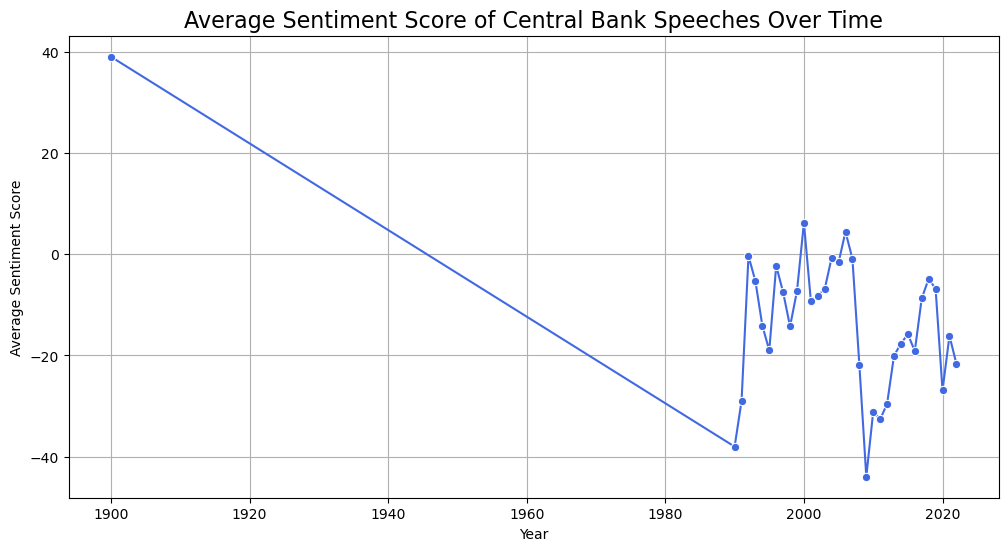

In [250]:
# Group by year and calculate average sentiment
yearly_sentiment = speeches_df.groupby(speeches_df['date'].dt.year)['sentiment_score'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_sentiment, x='date', y='sentiment_score', marker='o', color='royalblue')
plt.title('Average Sentiment Score of Central Bank Speeches Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

**3.2.b Outlier analysis**
- Descriptive Statistics: We'll calculate some basic descriptive statistics for the sentiment scores and other relevant numeric columns.
- Outlier Detection: We'll identify outliers using statistical methods like the Interquartile Range (IQR).
- Visualizing Outliers: We'll use boxplots to visually identify any outliers in the data.

Outliers detected:
          reference        country       date  \
40     r970812a_BOA      australia 1997-08-12   
83     r030606a_BOA      australia 2003-06-06   
151    r110211a_BOA      australia 2011-02-11   
157    r110826a_BOA      australia 2011-08-26   
244    r190809a_BOA      australia 2019-08-09   
...             ...            ...        ...   
7369  r160926a_FOMC  united states 2016-09-26   
7389  r161202a_FOMC  united states 2016-12-02   
7404  r170404a_FOMC  united states 2017-04-04   
7452  r180403a_FOMC  united states 2018-04-03   
7576  r200227a_FOMC  united states 2020-02-27   

                                                  title      author  is_gov  \
40                                                       macfarlane       1   
83                                                       macfarlane       1   
151                                                         stevens       1   
157                                                         stevens       1 

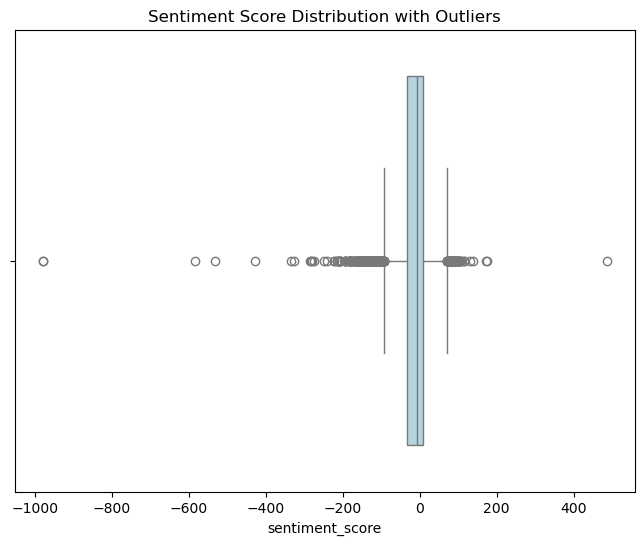

In [252]:
# Identify and visualize outliers using IQR
def detect_outliers_iqr(df, column):
    """Detect outliers using the Interquartile Range (IQR) method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Visualize outliers for 'sentiment_score'
outliers_df = detect_outliers_iqr(speeches_df, 'sentiment_score')
print("Outliers detected:")
print(outliers_df)

# Boxplot to visualize outliers
plt.figure(figsize=(8,6))
sns.boxplot(x=speeches_df['sentiment_score'], color='lightblue')
plt.title('Sentiment Score Distribution with Outliers')
plt.show()

**3.2.c. Wordcloud**<br>
visualize the most frequent words in the speeches.

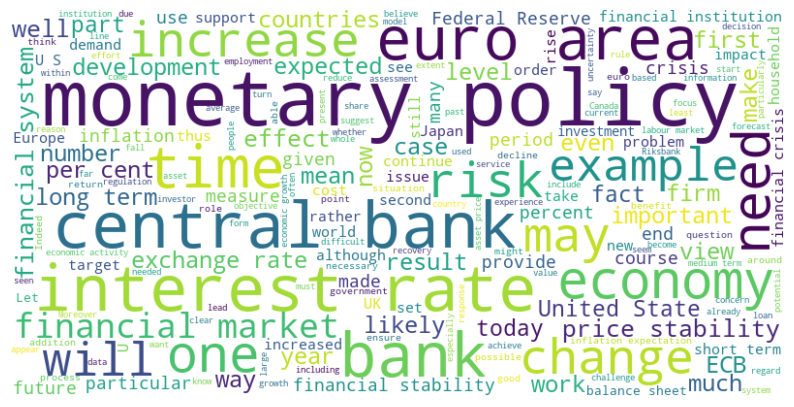

In [255]:
# Create a word cloud from the speech text
def generate_word_cloud(text_data):
    """Generate and plot a word cloud from the provided text."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud from the speeches
generate_word_cloud(speeches_df['text'])

Wordcloud after text preparation:
- Text Processing with NLTK: Tokenize: Split the text into individual words.
- Remove stopwords: Common words like "the", "and", "is", etc. which don't add significant meaning will be removed.
- Lemmatize: Reduce words to their root form (e.g., "running" becomes "run").
- Generate Word Cloud using NLTK-processed text.

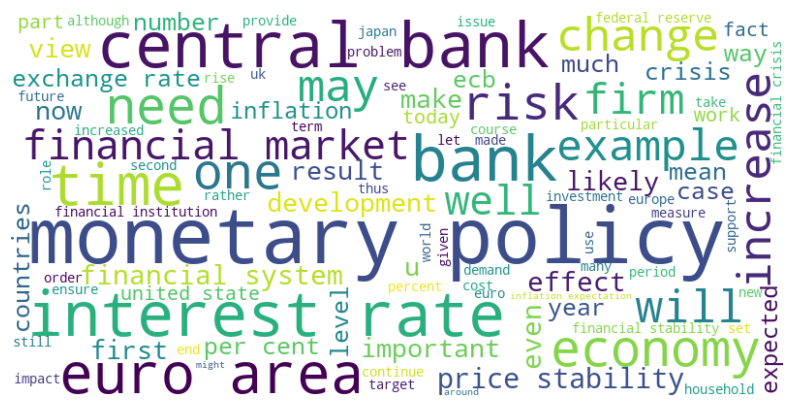

In [257]:
# Clean the text (remove any extra spaces, special characters, or stop words)
def clean_text_for_wordcloud(text):
    # Simple text cleaning: remove special characters and extra spaces
    text = str(text).lower()
    text = text.replace('\n', ' ')  # Remove line breaks
    text = ''.join(e for e in text if e.isalnum() or e.isspace())  # Keep only alphanumeric characters and spaces
    return text

# Clean the 'text' column in the dataframe
speeches_df['cleaned_text'] = speeches_df['text'].apply(clean_text_for_wordcloud)

# Combine all the speeches into a single string
all_text = ' '.join(speeches_df['cleaned_text'])

# Generate the word cloud
def generate_word_cloud(text_data):
    """Generate and plot a word cloud from the provided text."""
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          stopwords=None, max_words=100).generate(text_data)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.show()

# Generate the word cloud from cleaned text
generate_word_cloud(all_text)

### 3.3. Statistical Analysis of Sentiment Analysis

**3.3.a Heatmap to show correlation between sentiment score and year**

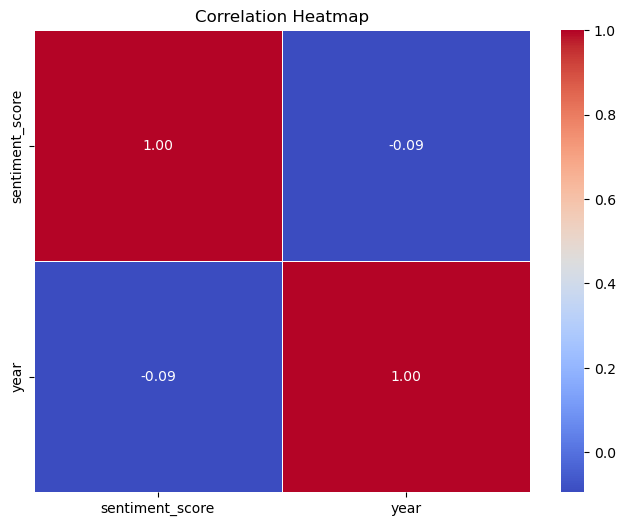

In [261]:
# Sample data (using your 'speeches_df' for example)
# If you have other numerical columns, feel free to add them to the DataFrame.
# For example, sentiment_score, date (converted to numerical), or any other relevant metrics.
speeches_df['date'] = pd.to_datetime(speeches_df['date'])  # Ensure 'date' is datetime format
speeches_df['year'] = speeches_df['date'].dt.year  # Extract year for analysis

# Compute correlations
correlation_matrix = speeches_df[['sentiment_score', 'year']].corr()

# Generate the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


**3.3.b Violin plot**<br>
A violin plot is a great way to visualize the distribution of a numerical variable (like the sentiment score) across different categories (like years, authors, or any other categorical variable). It combines aspects of both a box plot and a density plot, making it useful for understanding the distribution, spread, and outliers in the data.

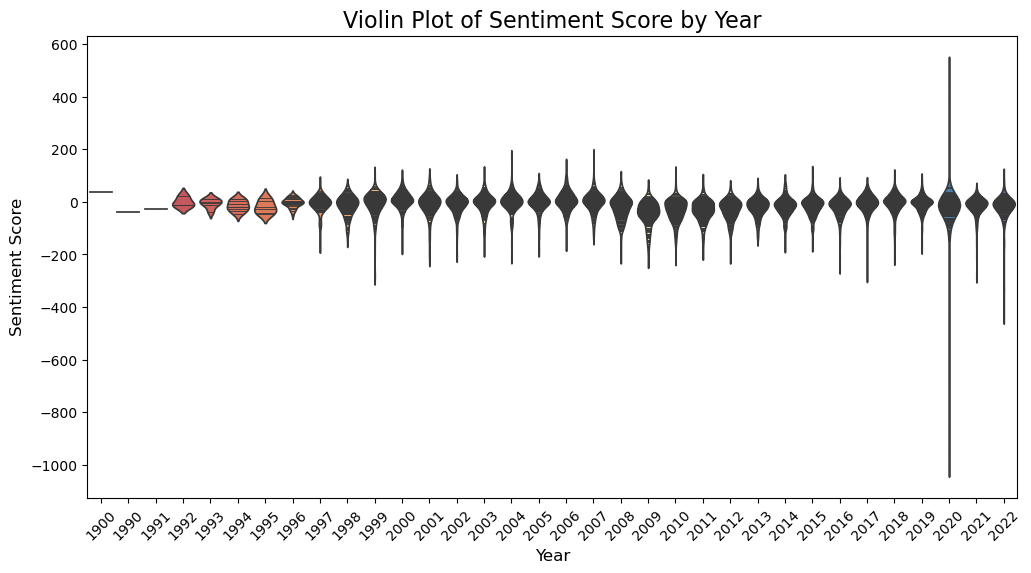

In [263]:
# Create the violin plot with colorful palette and different hues
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='sentiment_score', data=speeches_df, 
               palette='Spectral', inner='stick', scale='width')

# Adding labels and title
plt.title('Violin Plot of Sentiment Score by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()

**3.3.c Pairplot to visualise correlations**<br>
- sentiment_score
- year
- is_gov (for hue/marker differentiation)

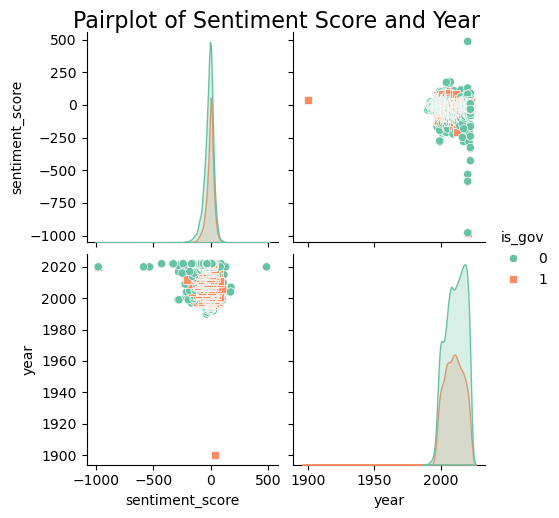

In [265]:
# Get the unique values of 'is_gov' to determine the number of markers
unique_values = speeches_df['is_gov'].unique()
num_unique_values = len(unique_values)

# Define your pairplot_columns
pairplot_columns = ['sentiment_score', 'year']

# Define enough markers for the unique values
markers = ['o', 's', 'D', 'X', '^', '<', '>']  # Adjust this list as needed

# Use the pairplot
sns.pairplot(speeches_df[pairplot_columns + ['is_gov']], hue='is_gov', palette='Set2', markers=markers[:num_unique_values])

# Adding a title
plt.suptitle('Pairplot of Sentiment Score and Year', fontsize=16, y=1.02)
plt.show()

**3.3.d IQR (Interquartile Range) Test for Outliers**<br>
The IQR method to detect outliers in numerical columns like sentiment_score and year.

In [267]:
# Calculate IQR for sentiment_score and year
Q1 = speeches_df[['sentiment_score', 'year']].quantile(0.25)
Q3 = speeches_df[['sentiment_score', 'year']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
outliers = (speeches_df[['sentiment_score', 'year']] < (Q1 - 1.5 * IQR)) | (speeches_df[['sentiment_score', 'year']] > (Q3 + 1.5 * IQR))

# Identify and display rows with outliers
outlier_rows = speeches_df[outliers.any(axis=1)]
print(outlier_rows)

          reference        country       date  \
40     r970812a_BOA      australia 1997-08-12   
83     r030606a_BOA      australia 2003-06-06   
151    r110211a_BOA      australia 2011-02-11   
157    r110826a_BOA      australia 2011-08-26   
244    r190809a_BOA      australia 2019-08-09   
...             ...            ...        ...   
7369  r160926a_FOMC  united states 2016-09-26   
7389  r161202a_FOMC  united states 2016-12-02   
7404  r170404a_FOMC  united states 2017-04-04   
7452  r180403a_FOMC  united states 2018-04-03   
7576  r200227a_FOMC  united states 2020-02-27   

                                                  title      author  is_gov  \
40                                                       macfarlane       1   
83                                                       macfarlane       1   
151                                                         stevens       1   
157                                                         stevens       1   
244           Op

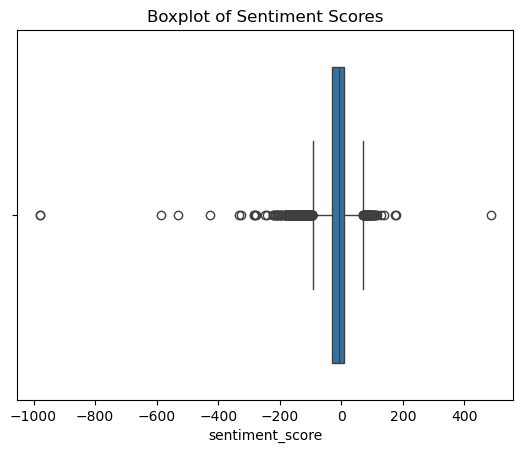

In [268]:
# Visualise the outliers in a boxplot to visually confirm the presence of outliers in sentiment_score or other numerical features.
sns.boxplot(x='sentiment_score', data=speeches_df)
plt.title('Boxplot of Sentiment Scores')
plt.show()

**3.3.e Skewness/Kurtosis**

In [270]:
skewness = speeches_df['sentiment_score'].skew()
kurtosis = speeches_df['sentiment_score'].kurtosis()
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Skewness: -3.861249948031232, Kurtosis: 66.84195249232052


**Observation**<br>
- Sentiment_score distribution is not normal.
- It has a lot of extreme outliers (especially on the negative side).
- Standard statistical tests assuming normality (like t-tests, simple linear regression without adjustments) might not be appropriate directly.

### 3.4. Statistical Analysis of Sentiment Analysis for Transformed sentiment score

**3.4.a Log transformation**

Transform the sentiment_score (e.g., log-transform, Box-Cox transform) to make it more normal-like.<br>
Since the data is negatively skewed, it is a good idea is to reflect it first (make it positive), then apply log transformation.

In [275]:
# Reflect the data (to deal with negative skew)
reflected_score = speeches_df['sentiment_score'].max() + 1 - speeches_df['sentiment_score']

# Apply log transformation
speeches_df['sentiment_score_log'] = np.log(reflected_score)

# Check skewness and kurtosis again
new_skewness = stats.skew(speeches_df['sentiment_score_log'])
new_kurtosis = stats.kurtosis(speeches_df['sentiment_score_log'], fisher=False)

print(f"New Skewness: {new_skewness:.4f}")
print(f"New Kurtosis: {new_kurtosis:.4f}")

New Skewness: -24.3956
New Kurtosis: 1451.9856


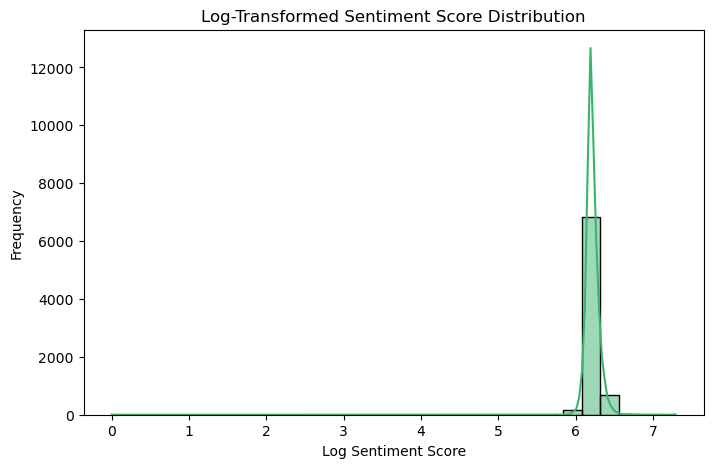

In [276]:
# Visualize the new distribution
plt.figure(figsize=(8,5))
sns.histplot(speeches_df['sentiment_score_log'], kde=True, color='mediumseagreen', bins=30)
plt.title('Log-Transformed Sentiment Score Distribution')
plt.xlabel('Log Sentiment Score')
plt.ylabel('Frequency')
plt.show()

**3.4.b Yeo-Johnson transformation**

Original sentiment_score has many zero or negative values (after reflection, some values might still cause issues with log so will use Yeo-Johnson transformation, which works for both positive and negative values ,no reflection needed, for better transformation.

In [279]:
# Create the transformer
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform
speeches_df['sentiment_score_yeojohnson'] = pt.fit_transform(speeches_df[['sentiment_score']])

# Check again
new_skewness = stats.skew(speeches_df['sentiment_score_yeojohnson'])
new_kurtosis = stats.kurtosis(speeches_df['sentiment_score_yeojohnson'], fisher=False)

print(f"New Skewness: {new_skewness:.4f}")
print(f"New Kurtosis: {new_kurtosis:.4f}")

New Skewness: -0.1610
New Kurtosis: 41.0174


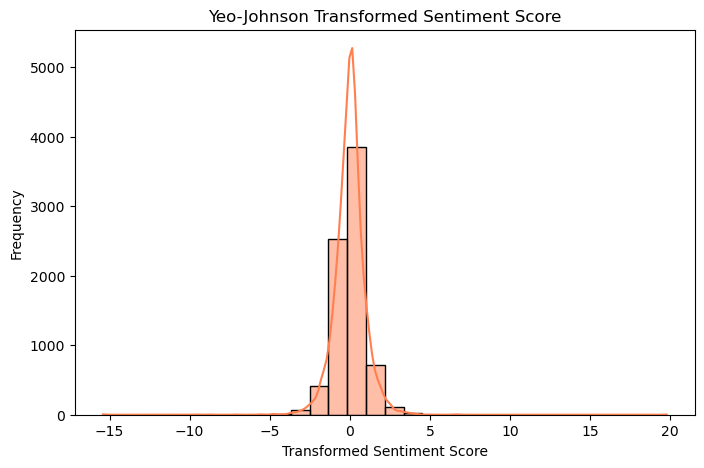

In [280]:
# Visualize the data
plt.figure(figsize=(8,5))
sns.histplot(speeches_df['sentiment_score_yeojohnson'], kde=True, color='coral', bins=30)
plt.title('Yeo-Johnson Transformed Sentiment Score')
plt.xlabel('Transformed Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### 3.5. Conclusions

**Skewness**:<br>
-0.1610 → Very close to 0, meaning almost symmetric which is excellent.<br>
 <br>
**Kurtosis**:<br>
41.0174 → Still high, meaning heavy tails (extreme values/outliers still exist).<br>
 <br>
=> Accept it — some heavy-tailedness is natural in financial text/sentiment data.

## 4. Exploratory Sentiment Analysis for BoE Speeches only

### 4.1. Prepare the data

In [286]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches_df_org[speeches_df_org['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10,1998,10,2311
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,4690
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,4452


In [287]:
boe_speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 4961 to 6169
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reference      1209 non-null   object        
 1   country        1209 non-null   object        
 2   date           1209 non-null   datetime64[ns]
 3   title          1209 non-null   object        
 4   author         1209 non-null   object        
 5   is_gov         1209 non-null   int64         
 6   text           1209 non-null   object        
 7   year_month     1209 non-null   object        
 8   year           1209 non-null   int32         
 9   month          1209 non-null   int32         
 10  speech_length  1209 non-null   int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(6)
memory usage: 103.9+ KB


In [288]:
# Governors
# Clean columns
boe_speeches["author"] = boe_speeches["author"].fillna("").str.strip()
boe_speeches["is_gov"] = 0  

# Edward George: 01‑Jul‑1993 → 30‑Jun‑2003
mask_george = (
    boe_speeches["author"].str.lower().str.contains("george")
    & (boe_speeches["date"] >= "1993-07-01")
    & (boe_speeches["date"] <= "2003-06-30")
)
boe_speeches.loc[mask_george, "is_gov"] = 1

# Mervyn King: 01‑Jul‑2003 → 30‑Jun‑2013
mask_king = (
    boe_speeches["author"].str.lower().str.contains("king")
    & (boe_speeches["date"] >= "2003-07-01")
    & (boe_speeches["date"] <= "2013-06-30")
)
boe_speeches.loc[mask_king, "is_gov"] = 1

# Mark Carney: 01‑Jul‑2013 → 15‑Mar‑2020
mask_carney = (
    boe_speeches["author"].str.lower().str.contains("carney")
    & (boe_speeches["date"] >= "2013-07-01")
    & (boe_speeches["date"] <= "2020-03-15")
)
boe_speeches.loc[mask_carney, "is_gov"] = 1

# Andrew Bailey: 16‑Mar‑2020 → present
mask_bailey = (
    boe_speeches["author"].str.lower().str.contains("bailey")
    & (boe_speeches["date"] >= "2020-03-16")
)
boe_speeches.loc[mask_bailey, "is_gov"] = 1

Speeches have been assigned to governors based on their official terms in office. For example, although Mervyn King delivered speeches as early as 1998, he only became Governor in July 2003. Prior to that, he held senior roles at the Bank of England—serving as Chief Economist and then Deputy Governor.

As such, only speeches delivered during his tenure as Governor (2003–2013) are labeled as governor speeches in the analysis. This approach ensures consistency and reflects the specific institutional role being evaluated.

In [290]:
boe_speeches["is_gov"].value_counts()

is_gov
0    1015
1     194
Name: count, dtype: int64

In [291]:
boe_speeches[boe_speeches["is_gov"] == 1]["author"].value_counts()
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,2311
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,4690
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,4452


In [292]:
# Text Pre-processing (clean & tokenise)

STOP_WORDS = set(stopwords.words('english'))

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'\d+', ' ', text.lower())  # drop numerals
    text = re.sub(r'[^\w\s]', ' ', text)     # drop punctuation
    tokens = [t for t in word_tokenize(text) if t not in STOP_WORDS]
    return ' '.join(tokens)

boe_speeches['clean_text'] = boe_speeches['text'].apply(clean)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length,clean_text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387,thank chairman actually pleased opportunity re...
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045,great pleasure beautiful city bruges honoured ...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,2311,industries suffered volatility british economy...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,4690,topic evening use forecasts economic policy ma...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,4452,six years ago week sterling left exchange rate...


### 4.2. Sentiment Analysis

**4.2.a Lexicon-based sentiment analysis**

In [295]:
# Prepare the lexicon
sentiment_lexicon = sentiment_df_org.copy()
categories = [
     "Negative",
     "Positive",
     "Uncertainty",
     "Litigious",
     "Strong",
     "Weak",
     "Constraining",
 ]
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, "Word"].str.lower())
    for cat in categories
}

def lexicon_counts(text: str) -> pd.Series:
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return pd.Series({cat: sum(t in word_sets[cat] for t in tokens) for cat in categories})

boe_speeches = pd.concat(
    [boe_speeches, boe_speeches["text"].apply(lexicon_counts)], axis=1
 )
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length,clean_text,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387,thank chairman actually pleased opportunity re...,63,39,24,3,20,16,2
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045,great pleasure beautiful city bruges honoured ...,87,82,52,6,39,30,16
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,2311,industries suffered volatility british economy...,61,33,49,2,11,17,5
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,4690,topic evening use forecasts economic policy ma...,78,43,92,11,31,42,15
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,4452,six years ago week sterling left exchange rate...,102,46,119,22,20,49,12


**using analysis in section 3 filtered for BoE speeches only**

In [297]:
# Bank OF England (UK) Speeches Only  
boe_speeches_df = speeches_df[speeches_df['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches_df.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,speech_length,cleaned_text,sentiment_score,sentiment_score_log,sentiment_score_yeojohnson
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,2387,thank you chairman im actually very pleased to...,-21,6.230481,-0.256736
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,4045,its a great pleasure to be here in the beautif...,-5,6.198479,0.078717
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10,1998,10,2311,few industries have suffered more from volatil...,-28,6.244167,-0.395595
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,4690,my topic this evening is the use of forecasts ...,-35,6.257668,-0.531654
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,4452,six years ago this week sterling left the exch...,-56,6.297109,-0.928035


**4.2.b Vader based sentiment analysis**

In [299]:
# Vader Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()
vader_scores = boe_speeches['clean_text'].apply(sia.polarity_scores).apply(pd.Series)
boe_speeches = pd.concat([boe_speeches, vader_scores], axis=1)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,...,Positive,Uncertainty,Litigious,Strong,Weak,Constraining,neg,neu,pos,compound
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,...,39,24,3,20,16,2,0.140,0.688,0.172,0.9952
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,...,82,52,6,39,30,16,0.100,0.679,0.221,0.9998
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,...,33,49,2,11,17,5,0.107,0.717,0.176,0.9977
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,...,43,92,11,31,42,15,0.070,0.780,0.150,0.9996
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,...,46,119,22,20,49,12,0.090,0.774,0.135,0.9990


In [300]:
# VADER Sentiment Labelling
def label_vader(c, thr=0.05):
    if c >  thr:
        return "Positive"
    if c < -thr:
        return "Negative"
    return "Neutral"

boe_speeches["Sentiment Label (VADER)"] = boe_speeches["compound"].apply(label_vader)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,...,Uncertainty,Litigious,Strong,Weak,Constraining,neg,neu,pos,compound,Sentiment Label (VADER)
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,...,24,3,20,16,2,0.140,0.688,0.172,0.9952,Positive
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,...,52,6,39,30,16,0.100,0.679,0.221,0.9998,Positive
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,...,49,2,11,17,5,0.107,0.717,0.176,0.9977,Positive
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,...,92,11,31,42,15,0.070,0.780,0.150,0.9996,Positive
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,...,119,22,20,49,12,0.090,0.774,0.135,0.9990,Positive


In [301]:
# Average VADER Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['compound', 'pos', 'neg', 'neu']]
      .mean()
      .round(3)           
                  
)

print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


,compound,pos,neg,neu
year,,,,
1998,0.997,0.168,0.108,0.723
1999,0.932,0.176,0.099,0.725
2000,0.944,0.205,0.087,0.708
2001,0.943,0.182,0.104,0.714
2002,0.930,0.194,0.106,0.700
2003,0.788,0.181,0.102,0.717
2004,0.858,0.173,0.092,0.734
2005,0.995,0.166,0.091,0.743
2006,0.823,0.172,0.097,0.731


**4.2.c Polarity & Subjectivity Analysis**

In [303]:
# Textblob Polarity & subjectivity.
def generate_polarity_subjectivity(dfs):
    dft2 = TextBlob(dfs).sentiment
    return pd.Series([dft2[0], dft2[1]])

# Apply the function to the data and add two new columns
boe_speeches[['polarity','subjectivity']] = boe_speeches['text'].apply(generate_polarity_subjectivity)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year_month,year,month,...,Strong,Weak,Constraining,neg,neu,pos,compound,Sentiment Label (VADER),polarity,subjectivity
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998-09,1998,9,...,20,16,2,0.140,0.688,0.172,0.9952,Positive,0.083288,0.435206
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998-10,1998,10,...,39,30,16,0.100,0.679,0.221,0.9998,Positive,0.076868,0.368726
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998-10,1998,10,...,11,17,5,0.107,0.717,0.176,0.9977,Positive,0.091432,0.394993
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11,1998,11,...,31,42,15,0.070,0.780,0.150,0.9996,Positive,0.086707,0.476692
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11,1998,11,...,20,49,12,0.090,0.774,0.135,0.9990,Positive,0.058314,0.393456


In [304]:
# TextBlob  (polarity & subjectivity) per year
tb_yearly = (
    boe_speeches
        .groupby("year")[["polarity", "subjectivity"]]   
        .mean()                                          
        .round(3)                                        
)

print("\nAverage TextBlob polarity & subjectivity per year:")
tb_yearly


Average TextBlob polarity & subjectivity per year:


,polarity,subjectivity
year,,
1998,0.082,0.415
1999,0.091,0.407
2000,0.118,0.428
2001,0.099,0.421
2002,0.101,0.420
2003,0.098,0.417
2004,0.087,0.412
2005,0.093,0.429
2006,0.090,0.413


### 4.3. Visualisations

In [307]:
# Speech count per year
fig1 = px.histogram(
    boe_speeches,
    x="year",
    nbins=23,
    title="Number of Bank of England speeches per year (1997–2022)",
)
fig1.update_layout(bargap=0.2)
 
fig1.show()

In [308]:
# Average speech length per year
length_by_year = (
     boe_speeches.groupby("year")["speech_length"].mean().reset_index()
)
fig2 = px.line(
     length_by_year,
     x="year",
     y="speech_length",
     title="Average speech length – Bank of England (2000–2022)",
     labels={"speech_length": "Words"},
)
fig2.update_traces(mode="lines+markers")
fig2.show()

In [309]:
# Normalized sentiment columns (per word).
for cat in categories:
    boe_speeches[f"{cat}_norm"] = boe_speeches[cat] / boe_speeches["speech_length"]

# Normalized columns (per word/speech length)
categories_norm = [f"{cat}_norm" for cat in categories]

# Average per year
lexicon_yearly = boe_speeches.groupby("year")[categories_norm].mean().reset_index()

# Plot the categories
fig3 = px.line(
    lexicon_yearly,
    x="year",
    y=["Uncertainty_norm", "Negative_norm", "Positive_norm"],
    title="Lexicon-based sentiment trends over time (BoE Speeches)",
    labels={"value": "Normalized score", "variable": "Sentiment Category"},
)
fig3.update_traces(mode="lines+markers")
fig3.show()

# Adding important events
fig3.add_vline(x=2008, line_dash="dot", line_color="red", annotation_text="Global Financial Crisis", annotation_position="top left")
fig3.add_vline(x=2016, line_dash="dot", line_color="orange", annotation_text="Brexit Vote", annotation_position="top left")
fig3.add_vline(x=2020, line_dash="dot", line_color="green", annotation_text="COVID-19", annotation_position="top left")
fig3.show()

**Note: While we could include other categories such as "Litigious," "Strong," "Weak," and "Constraining", the categories "Positive," "Negative," and "Uncertainty" are more relevant and meaningful for our analysis, both in terms of interpretability and alignment with the study’s objectives.**

The chart shows how normalized sentiment in Bank of England speeches has changed over time, reflecting key economic events:

* **Negative sentiment** peaks sharply during the 2008 financial crisis and remains elevated through much of the 2010s before gradually declining.

* **Positive sentiment** is highest in the early years (1998–2000) but stays low and stable afterward.

* **Uncertainty** rises moderately during Brexit (2016) and COVID-19 (2020), with a noticeable spike in the early 2000s.

The timing of sentiment shifts aligns with major events, suggesting that the Bank’s communication tone becomes more negative or uncertain during periods of economic stress.

In [312]:
# Average VADER sentiment per year
vader_yearly = boe_speeches.groupby("year")[["pos", "neg", "neu", "compound"]].mean().reset_index()
fig3 = px.line(
     vader_yearly,
     x="year",
     y=["pos", "neg", "neu", "compound"],
     title="Average VADER sentiment scores – Bank of England speeches (1997–2022)",
     labels={"value": "Average score", "variable": "Metric"},
)
fig3.update_traces(mode="lines+markers")
fig3.show()

**Observations**:<br>
The full-panel VADER plot provides a richer decomposition of the Bank’s language. Across the entire 1997-2022 window the neutral share (green) hovers close to 0.70—evidence that most sentences remain informational, as one would expect from a central-bank charged with projecting authority and clarity. Within the residual 30 % of “sentiment-bearing” content, the positive fraction (blue, ≈ 0.16-0.21) consistently outweighs the negative fraction (red, ≈ 0.09-0.12), yielding a strongly positive compound score (violet) that rarely dips below 0.50. Yet those dips line up precisely with the key stress episodes highlighted in the project brief: a first slide in 2008-09 during the global-financial crisis, a second in 2011-12 amid euro-area tensions, and the deepest drop in 2020 when Covid-19 struck. Each time, the Bank’s speeches became less upbeat (falling compound, rising negative share), but the neutral component remained dominant, signalling that the institution continued to anchor expectations through factual, measured communication. The rapid rebounds in 2013-14 and again in 2021 also illustrate how the Bank modulates its tone upward as soon as macro-financial conditions stabilise, reinforcing its mandate to reassure markets while supporting the United Kingdom’s monetary and financial stability.

In [314]:
# Plot with Compound and Events 
fig4 = px.line(
    vader_yearly,
    x="year",
    y="compound",
    title="Average VADER compound sentiment – BoE Speeches (1997–2022)",
    labels={"compound": "Compound Sentiment", "year": "Year"}
)
fig4.update_traces(mode="lines+markers")
# Add event lines
fig4.add_vline(x=2008, line_dash="dot", line_color="red", annotation_text="Global Financial Crisis")
fig4.add_vline(x=2016, line_dash="dot", line_color="orange", annotation_text="Brexit Vote")
fig4.add_vline(x=2020, line_dash="dot", line_color="green", annotation_text="COVID-19")
fig4.show()

This chart displays the average VADER compound sentiment of Bank of England speeches from 1997 to 2022, with major events highlighted.

* The overall tone of speeches remains strongly positive before 2008, with average compound scores close to 1.0, indicating consistently optimistic language.

* A noticeable decline occurs during the 2008 Global Financial Crisis, with sentiment dropping significantly, reflecting a more cautious or negative communication style.

* Sentiment compound recovers after 2010 but shows more volatility in the following years.

* Around the 2016 Brexit referendum, sentiment dips again, though not as sharply.

* A steep decline is observed in 2020, aligning with the COVID-19 pandemic, where the compound score reaches its lowest point in the time series, indicating a highly negative or uncertain tone.

* Post-COVID, sentiment shows some rebound but remains lower than pre-2008 levels.

This trend supports the idea that VADER sentiment scores reflect the Bank’s shifting tone in response to external crises, offering a useful general-purpose measure alongside lexicon-based sentiment.

In [316]:
# Polarity & subjectivity 
fig_tb_combo = px.line(
    tb_yearly.reset_index(),            
    x="year",
    y=["polarity", "subjectivity"],
    title="Average TextBlob polarity and subjectivity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric", "year": "Year"},
)
fig_tb_combo.update_traces(mode="lines+markers")
fig_tb_combo.show()

**Observations**:<br>
The TextBlob results confirm that, in fulfilling its mandate to “promote the good of the people of the United Kingdom by maintaining monetary and financial stability,” the Bank of England adopts a remarkably steady rhetorical stance. Average polarity (blue line) stays modestly positive—between ≈ 0.08 and 0.11—for the entire 1997-2022 sample, signalling a deliberately reassuring tone that fits the Bank’s role as an anchor for market expectations. The small but clear troughs in 2001-03 (post-dot-com slowdown), 2008-12 (global-financial and euro-area crises) and 2020 (COVID-19 shock) show that even this cautious measure registers periods of heightened concern, before rebounding as conditions stabilise—evidence that the Bank’s communications react to macro-financial stress but avoid excessive pessimism.

By contrast, subjectivity (orange line) hovers narrowly around 0.40-0.43 throughout. In practical terms this means that roughly 60 % of each speech is factual or data-driven while the remaining 40 % contains interpretative or forward-looking statements. The near-flat profile—barely affected by the crises noted above—suggests that, whatever the economic backdrop, the Bank maintains a consistent mix of analysis and judgement in its public messaging. This stylistic stability is fully aligned with its strategic objective: to provide markets and households with dependable guidance, neither overly technical nor unduly emotive, thereby supporting monetary-policy credibility and overall financial stability.

In [318]:
# Compound and Polarity 
combo = vader_yearly.merge(tb_yearly, on="year")

fig_combo = px.line(
    combo,
    x="year",
    y=["compound", "polarity"],
    title="VADER compound vs TextBlob polarity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric"}
)
fig_combo.update_traces(mode="lines+markers")
fig_combo.show()

**Observations**: <br>
The combined plot of VADER compound (blue) and TextBlob polarity (red) summarises how the overall tone of Bank-of-England speeches has evolved since 1998. Although the two indices are reported on the same vertical axis, their scales differ: VADER’s non-linear formula pushes values close to +1 whenever positive language dominates, whereas TextBlob remains tightly compressed (≈ 0.07–0.12). For that reason we interpret the curves in terms of directional changes, not absolute height.

Both series move in lock-step: plateaus at high levels through the late-1990s and early-2000s; an unmistakable dip during the global-financial crisis (2007-09); a second trough in 2011-12 as euro-area turmoil intensified; and a sharp collapse in 2020 at the onset of the Covid-19 shock, followed by an incomplete rebound in 2021-22. The fact that the “quiet” polarity line tracks every rise and fall in the more volatile compound line confirms that the signal is real rather than a model artefact. In practical terms, VADER offers a high-resolution “early-warning” indicator, while TextBlob provides a stable baseline for long-run trend analysis. Taken together, the two metrics show that the Bank consistently adopts a mildly positive tone, yet still modulates that tone noticeably in response to major episodes of macro-financial stress, exactly as one would expect from an institution whose communications are meant to reassure markets while reflecting underlying economic realities.

In [320]:
# Mean sentiment scores grouped by is_gov
avg_sentiment = (
    boe_speeches
    .groupby("is_gov")[["compound", "polarity", "Positive_norm", "Negative_norm", "Uncertainty_norm"]]
    .mean()
    .reset_index()
)

# Map to role and drop 'is_gov' before melting
avg_sentiment["Role"] = avg_sentiment["is_gov"].map({1: "Governor", 0: "Non-Governor"})
avg_sentiment = avg_sentiment.drop(columns="is_gov")

# Melt for plotting
melted = avg_sentiment.melt(id_vars="Role", var_name="Metric", value_name="Score")

# Plot
fig_avg_sent = px.bar(
    melted,
    x="Metric",
    y="Score",
    color="Role",
    barmode="group",
    title="Average Sentiment Scores – Governor vs Non-Governor Speeches",
    height=500
)
fig_avg_sent.show()

This chart compares the average sentiment scores across speeches given by governors and non-governors of the Bank of England.

* Governors show higher compound and polarity scores, indicating a more consistently positive and confident tone in their speeches.

* Lexicon-based sentiment (positive, negative, uncertainty) is very similar across both groups, but governors exhibit slightly more positivity and less uncertainty.

* The lower sentiment scores among non-governors suggest a tone that may be more analytical, cautious, or varied depending on the role and context.

These differences reflect the governor’s institutional role in projecting stability, while non-governors may offer more technical or critical perspectives.

In [322]:
# Group by year and is_gov
by_year_role = (
    boe_speeches
    .groupby(["year", "is_gov"])["compound"]
    .mean()
    .reset_index()
)
by_year_role["Role"] = by_year_role["is_gov"].map({1: "Governor", 0: "Non-Governor"})

fig_gov = px.line(
    by_year_role,
    x="year",
    y="compound",
    color="Role",
    title="VADER Compound Sentiment Over Time – Governor vs Non-Governor",
    markers=True,
    labels={"compound": "Compound Sentiment"},
)
fig_gov.show()

Governor speeches show consistently higher and more stable sentiment (compound scores near 0.9–1.0), reflecting a reassuring and authoritative tone aligned with the Bank’s stabilizing role.

Non-governor speeches are more volatile and dip more sharply during crises (e.g. 2008, 2020), suggesting they may express concern or analytical caution more directly.

The contrast highlights how governors maintain confidence, while others reflect stress more openly.

### 4.4 Accuracy Testing

In [401]:
sample_boe = boe_speeches[
    ["reference", "date", "author", "clean_text", 
     "pos", "neg", "neu", "compound", "Sentiment Label (VADER)"]
].sample(n=40, random_state=42)

sample_boe["Manual_Sentiment_Label"] = ""

sample_boe.to_csv("sample_boe_for_labeling.csv", index=False)

In [403]:
# Load manually labeled file
labeled_sample_boe = pd.read_excel("sample_boe_for_labeling.xlsx")  

In [405]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compare VADER predictions with manual labels
accuracy = accuracy_score(labeled_sample_boe["Sentiment Label (VADER)"], labeled_sample_boe["Manual_Sentiment_Label"])
precision = precision_score(labeled_sample_boe["Sentiment Label (VADER)"], labeled_sample_boe["Manual_Sentiment_Label"], average="weighted")
recall = recall_score(labeled_sample_boe["Sentiment Label (VADER)"], labeled_sample_boe["Manual_Sentiment_Label"], average="weighted")
f1 = f1_score(labeled_sample_boe["Sentiment Label (VADER)"], labeled_sample_boe["Manual_Sentiment_Label"], average="weighted")

# Results
print("VADER Sentiment Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

VADER Sentiment Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


### 4.5. Conclusion on Sentiment Analysis of Bank of England speeches

The combined analysis of lexicon-based, VADER, and TextBlob sentiment metrics reveals a clear and consistent pattern:

* The Bank of England adjusts the tone of its public communications in response to major economic disruptions, adopting a more negative and uncertain sentiment during periods such as the 2008 global financial crisis, the euro-area tensions in 2011–2012, the 2016 Brexit referendum, and the 2020 COVID-19 pandemic.

* While VADER captures overall tone shifts with high sensitivity, the lexicon-based method highlights changes in specific emotional dimensions like uncertainty and negativity, and TextBlob confirms a steady but responsive rhetorical baseline. Together, these tools show that the Bank's speeches remain largely neutral and informative—as expected from a central bank—but do exhibit noticeable tonal adjustments that reflect macro-financial stress.

* Importantly, speeches delivered by governors tend to exhibit consistently higher and more stable sentiment, reinforcing their role in projecting confidence and institutional stability. In contrast, non-governor speeches are more volatile and often reflect sharper sentiment declines during crises, offering a more analytical or reactive tone that complements the Bank’s broader communication strategy.

These results support the idea that BoE communications not only anchor market expectations but also react systematically to economic conditions, offering potential predictive value and insight into institutional sentiment.

## 5. Exploratory Analysis for Correlation with Economic Indicators

Correlate with Inflation, GDP Merge UK macro data (ONS GDP growth, CPI, unemployment).

Calculate correlation coefficients.

Plot heatmap.

## 6. Insights & Recommendations